# Part 1: Spoof Detection

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.1 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTFeatureExtractor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from datasets import load_dataset
from PIL import Image
import numpy as np
import os

In [ ]:
#loading CelebA Dataset
dataset = load_dataset("nguyenkhoa/celeba-spoof-for-face-antispoofing-test")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/437 [00:00<?, ?B/s]

test-00000-of-00010.parquet:   0%|          | 0.00/496M [00:00<?, ?B/s]

test-00001-of-00010.parquet:   0%|          | 0.00/493M [00:00<?, ?B/s]

test-00002-of-00010.parquet:   0%|          | 0.00/494M [00:00<?, ?B/s]

test-00003-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00004-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

test-00005-of-00010.parquet:   0%|          | 0.00/499M [00:00<?, ?B/s]

test-00006-of-00010.parquet:   0%|          | 0.00/500M [00:00<?, ?B/s]

test-00007-of-00010.parquet:   0%|          | 0.00/498M [00:00<?, ?B/s]

test-00008-of-00010.parquet:   0%|          | 0.00/487M [00:00<?, ?B/s]

test-00009-of-00010.parquet:   0%|          | 0.00/495M [00:00<?, ?B/s]

Generating test split:   0%|          | 0/67170 [00:00<?, ? examples/s]

## Data Preprocessing

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 67170
    })
})

In [ ]:
#Removing null values
dataset = dataset.filter(lambda example: example["cropped_image"] is not None)

Filter:   0%|          | 0/67170 [00:00<?, ? examples/s]

In [ ]:
dataset

DatasetDict({
    test: Dataset({
        features: ['cropped_image', 'labels', 'labelNames'],
        num_rows: 66787
    })
})

In [ ]:
dataset['test'].features #label=0 is 'live' and label=1 is 'spoof'

{'cropped_image': Image(mode=None, decode=True, id=None),
 'labels': ClassLabel(names=['live', 'spoof'], id=None),
 'labelNames': Value(dtype='string', id=None)}

## Visualization

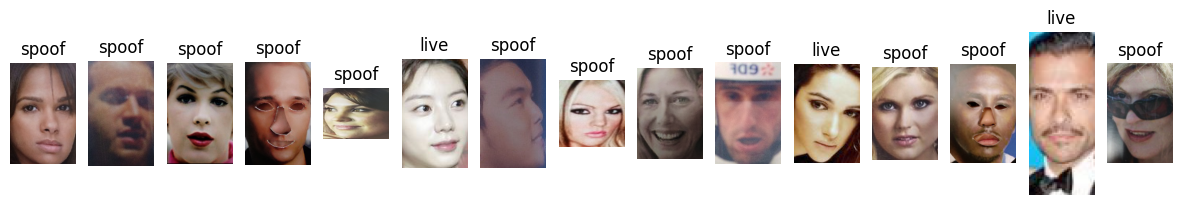

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(15):
    label=dataset['test'][i]['labelNames']
    plt.subplot(1, 15, i + 1)
    plt.imshow(dataset['test'][i]["cropped_image"])
    plt.title(label)
    plt.axis("off")


plt.show()

## Train-Test-Val Split

In [ ]:
#split the training data into train and test
train_test_split=dataset['test'].train_test_split(test_size=0.3,seed=42)

#split the training data into train and validation
train_val_split=train_test_split['train'].train_test_split(test_size=0.2,seed=42)

train_data=train_val_split['train']
val_data=train_val_split['test']
test_data=train_test_split['test']

In [ ]:
print('Train: ', train_data)
print('Val: ', val_data)
print('Test: ', test_data)

Train:  Dataset({
    features: ['cropped_image', 'labels', 'labelNames'],
    num_rows: 37400
})
Val:  Dataset({
    features: ['cropped_image', 'labels', 'labelNames'],
    num_rows: 9350
})
Test:  Dataset({
    features: ['cropped_image', 'labels', 'labelNames'],
    num_rows: 20037
})


In [ ]:
id2label={id: label for id, label in enumerate(train_data.features["labels"].names)}
label2id={label: id for id, label in id2label.items()}

print('id2label: ', id2label)
print('label2id: ', label2id)

id2label:  {0: 'live', 1: 'spoof'}
label2id:  {'live': 0, 'spoof': 1}


## Image processing and transformation

For effective image processing with ViT models, it’s essential to use a ViTImageProcessor configured with the same settings as the pre-trained model.

In [ ]:
from transformers import ViTImageProcessor

model_name="google/vit-base-patch16-224"
processor=ViTImageProcessor.from_pretrained(model_name)
processor

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

ViTImageProcessor {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [ ]:
from torchvision.transforms import CenterCrop,Compose,Normalize,RandomHorizontalFlip,RandomResizedCrop,ToTensor,Resize

#image configurations from ViT processor
image_mean, image_std=processor.image_mean, processor.image_std
size=processor.size["height"]

#normalizes the image pixels by subtracting the mean and dividing by the std of pretrained model configurations
normalize=Normalize(mean=image_mean, std=image_std)

In [ ]:
#Compose combines a series of image transformations into one pipeline.
train_transforms=Compose(
    [
        RandomResizedCrop(size),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms=Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

test_transforms=Compose(
    [
        Resize(size),
        CenterCrop(size),
        ToTensor(),
        normalize,
    ]
)

In [ ]:
def apply_train_transforms(examples):
    examples["pixel_values"]=[train_transforms(image.convert("RGB")) for image in examples["cropped_image"]]
    return examples


def apply_val_transforms(examples):
    examples["pixel_values"]=[val_transforms(image.convert("RGB")) for image in examples["cropped_image"]]
    return examples


def apply_test_transforms(examples):
    examples["pixel_values"]=[val_transforms(image.convert("RGB")) for image in examples["cropped_image"]]
    return examples



In [ ]:
train_data.set_transform(apply_train_transforms)
val_data.set_transform(apply_val_transforms)
test_data.set_transform(apply_test_transforms)

In [ ]:
def collate_fn(examples):
    #stacks the pixel values of all examples into a single tensor and collects labels into a seperate tensor
    pixel_values=torch.stack([example["pixel_values"] for example in examples])
    labels=torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

train_loader=DataLoader(train_data, collate_fn=collate_fn, batch_size=32, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Model Training

In [ ]:
from transformers import ViTForImageClassification

labels=dataset['test'].features['labels'].names

model=ViTForImageClassification.from_pretrained(
    model_name,
    num_labels = len(labels), #change the classification head of the model with num of output classes
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#configuration
from transformers import TrainingArguments, Trainer
import numpy as np

train_args = TrainingArguments(
    output_dir="output-models",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  save_steps=500,
  eval_steps=500,
  logging_steps=500,
  save_total_limit=2,
  num_train_epochs=2,
  learning_rate=2e-4,
  fp16=True,
  remove_unused_columns=False,
  push_to_hub=False,
    report_to='none'
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer=Trainer(
    model,
    train_args,
    train_dataset=train_data,
    eval_dataset=val_data,
    data_collator=collate_fn,
    tokenizer=processor,
)
trainer.train()

<ipython-input-37-6244aa05bfa6>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss,Validation Loss
500,0.032500,0.023390
1000,0.022900,0.022451
1500,0.012000,0.010794
2000,0.009900,0.010241


TrainOutput(global_step=2338, training_loss=0.017474509794758977, metrics={'train_runtime': 1343.3127, 'train_samples_per_second': 55.683, 'train_steps_per_second': 1.74, 'total_flos': 5.796400823171482e+18, 'train_loss': 0.017474509794758977, 'epoch': 2.0})

In [ ]:
model.save_pretrained("final_model")
processor.save_pretrained("final_model")

['final_model/preprocessor_config.json']

## Evaluation

In [ ]:
outputs=trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.004663547500967979, 'test_runtime': 189.2849, 'test_samples_per_second': 105.856, 'test_steps_per_second': 13.234}


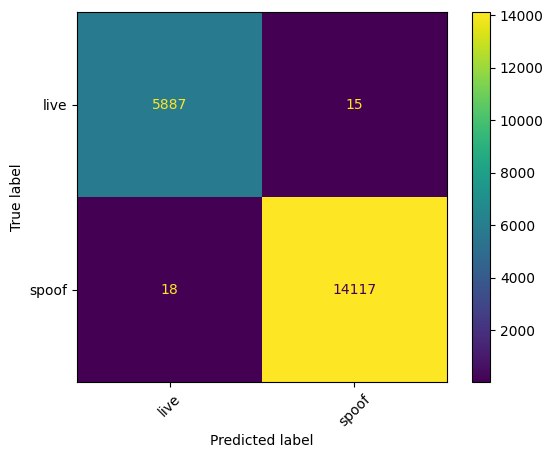

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true=outputs.label_ids
y_pred=outputs.predictions.argmax(1)

labels=train_data.features["labels"].names
cm=confusion_matrix(y_true, y_pred)
disp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(xticks_rotation=45)

In [ ]:
accuracy=accuracy_score(y_true, y_pred)
print(f'Accuracy: {accuracy:.4f}')

precision=precision_score(y_true, y_pred, average='weighted')
print(f'Precision: {precision:.4f}')

recall=recall_score(y_true, y_pred, average='weighted')
print(f'Recall: {recall:.4f}')

f1=f1_score(y_true, y_pred, average='weighted')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.9984
Precision: 0.9984
Recall: 0.9984
F1-Score: 0.9984
